install packages

In [ ]:
!pip install transformers
!pip install gluonnlp
!pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=661770 sha256=27b945a415ce886490a4d70f276c8666b9d4069350797f11176c9c47a18b9f14
  Stored in directory: /root/.cache/pip/wheels/1a/1e/0d/99f55911d90f2b95b9f7c176d5813ef3622894a4b30fde6bd3
Successfully built gluonnlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


import packages

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

Set the device according to runtime environment

In [ ]:
device = torch.device("cuda:0") # GPU
# device = torch.device('cpu') # CPU

Connect with google drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
gdrive_path = "/content/gdrive/My Drive/Hackathon/" # change it according to file path

Mounted at /content/gdrive


Load pre-trained Korean BERT model

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

# Load KoBERT model and tokenizer
model_name = "BM-K/KoSimCSE-roberta-multitask"

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name,  num_labels = 2, output_attentions = False, output_hidden_states = False).to(device)
# model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/764 [00:00<?, ?B/s]

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at BM-K/KoSimCSE-roberta-multitask and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load dataset

In [ ]:
import csv

testing_size = 10000 # small sample for test-training
true_size = 20000 # actual sample size for fine-tuning (4M is too much for free colab)

# From NIKL database, only load articles from 중앙일보 and 한겨레
# WARNING: dataset is not included in the github file due to the license. To use the dataset, you must get permission from https://kli.korean.go.kr/corpus/request/corpusRegist.do
dataset_path = gdrive_path + "dataset/dataset.csv"

dataset_all = pd.read_csv(dataset_path, header=None, names=['file_id',	'doc_id',	'title',	'author',	'publisher',	'date',	'topic',	'original_topic',	'sentence_id',	'sentence'])
dataset = dataset_all.sample(true_size)

print(dataset.sample(10))

<ipython-input-10-4e72d77cd3e9>:9: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_all = pd.read_csv(dataset_path, header=None, names=['file_id',	'doc_id',	'title',	'author',	'publisher',	'date',	'topic',	'original_topic',	'sentence_id',	'sentence'])


                file_id                doc_id          title  \
2518401  NWRW1900000010   NWRW1900000010.2029  조선일보 2018년 기사   
2983697  NWRW1900000052   NWRW1900000052.7465   한겨레 2010년 기사   
2152684  NWRW1900000008  NWRW1900000008.15924  조선일보 2016년 기사   
242177   NWRW1900000001  NWRW1900000001.14275  조선일보 2009년 기사   
73302    NWRW1800000040    NWRW1800000040.413   한겨레 2013년 기사   
1170216  NWRW1900000004  NWRW1900000004.20596  조선일보 2012년 기사   
1925772  NWRW1900000007  NWRW1900000007.17366  조선일보 2015년 기사   
865384   NWRW1900000003  NWRW1900000003.20102  조선일보 2011년 기사   
2087647  NWRW1900000008   NWRW1900000008.8748  조선일보 2016년 기사   
1385917  NWRW1900000005  NWRW1900000005.12752  조선일보 2013년 기사   

                            author publisher      date  topic  \
2518401                        이해인     조선일보사  20180129     연예   
2983697                        이형섭       한겨레  20100427     생활   
2152684                        이순태     조선일보사  20160729     사회   
242177                         김재곤 

In [ ]:
sentences = dataset.sentence.values
labels = dataset.publisher.values
topics = dataset.topic.values

for i in range(len(labels)):
  labels[i] = ["한겨레", "조선일보사"].index(labels[i])

labels = labels.astype(int)

In [ ]:
## Setting parameters
max_len = 128
batch_size = 32
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sentence in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True
                   )
    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  2000년대 중반부터 라디오 방송에서 휴대전화 문자로 사연을 받으면서 사람 이름 대신 뒷번호를 부르는 관행이 생겼다. 젊은 층이 많이 듣는 가요 프로그램뿐 아니라 중장년층이 많이 듣는 클래식 프로그램에서도 숫자로 청취자를 소개한다. 하지만 권씨처럼 중장년층 라디오 청취자 중에는 이 관행이 어색하다고 말하는 사람이 많다.
Token IDs: tensor([    0,  4470,  2440,  2104,  7319,  3797,  6526,  3861, 27135,  5204,
         2165,  2267,  5703,  2200,  7871,  2069,  1122, 19292,  3611,  3934,
         4217,   874,  2517,  2016,  2138,  4681,  2259,  7939,  2052,  5810,
         2062,    18,  1539,  2073,  1688,  2052,  3732,   881,  2259,  7390,
         3969,  2782,  3614,  2181, 15093,  2440,  2624,  2052,  3732,   881,
         2259,  7364,  3969, 27135,  2119,  6197,  2200, 15935,  2138,  4348,
         4538,    18,  3696,   627,  2483,  7925, 15093,  2440,  2624,  6526,
        15935,  1570,  2170,  2259,  1504,  7939,  2052,  9977,  2205,  4683,
         1041,  2205,  2259,  3611,  2052,  1039,  2062,    18,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,    

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

9,000 training samples
1,000 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
# batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW( model.parameters(), lr = learning_rate )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * num_epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np
from math import *

sigmoid = lambda x: 1 / (1 + np.exp(-x)) # sigmoid function

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels): # using sigmoid function to ensure the value stays between 0 and 1
    pred_flat = [sigmoid(val[1] - val[0]) for val in preds]
    # pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(1 - abs(pred_flat - labels_flat)) / len(labels_flat)

print(flat_accuracy([[1000, 0]], np.array([0]))) # 1.00

1.0


<ipython-input-13-ff269004f6db>:4: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: 1 / (1 + np.exp(-x)) # sigmoid function


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as nps


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 69420 # nice number

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, num_epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):


        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print("")
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss, logits = output.loss, output.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        print("|", end = "")
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
            loss, logits = output.loss, output.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
||||||||||||||||||||||||||||||||||||||||
  Batch    40  of    563.    Elapsed: 0:00:24.
||||||||||||||||||||||||||||||||||||||||
  Batch    80  of    563.    Elapsed: 0:00:48.
||||||||||||||||||||||||||||||||||||||||
  Batch   120  of    563.    Elapsed: 0:01:12.
||||||||||||||||||||||||||||||||||||||||
  Batch   160  of    563.    Elapsed: 0:01:36.
||||||||||||||||||||||||||||||||||||||||
  Batch   200  of    563.    Elapsed: 0:02:00.
||||||||||||||||||||||||||||||||||||||||
  Batch   240  of    563.    Elapsed: 0:02:25.
||||||||||||||||||||||||||||||||||||||||
  Batch   280  of    563.    Elapsed: 0:02:50.
||||||||||||||||||||||||||||||||||||||||
  Batch   320  of    563.    Elapsed: 0:03:15.
||||||||||||||||||||||||||||||||||||||||
  Batch   360  of    563.    Elapsed: 0:03:40.
||||||||||||||||||||||||||||||||||||||||
  Batch   400  of    563.    Elapsed: 0:04:06.
||||||||||||||||||||||||||||||||||||||||
  Batch   440  of    563.    Elapsed

In [ ]:
# Display floats with two decimal places.
pd.options.display.precision = 2

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.30,0.23,0.85,0:05:51,0:00:14
2,0.19,0.27,0.86,0:06:05,0:00:14
3,0.10,0.39,0.91,0:06:04,0:00:14
4,0.04,0.47,0.91,0:06:04,0:00:14
5,0.01,0.57,0.91,0:06:04,0:00:14


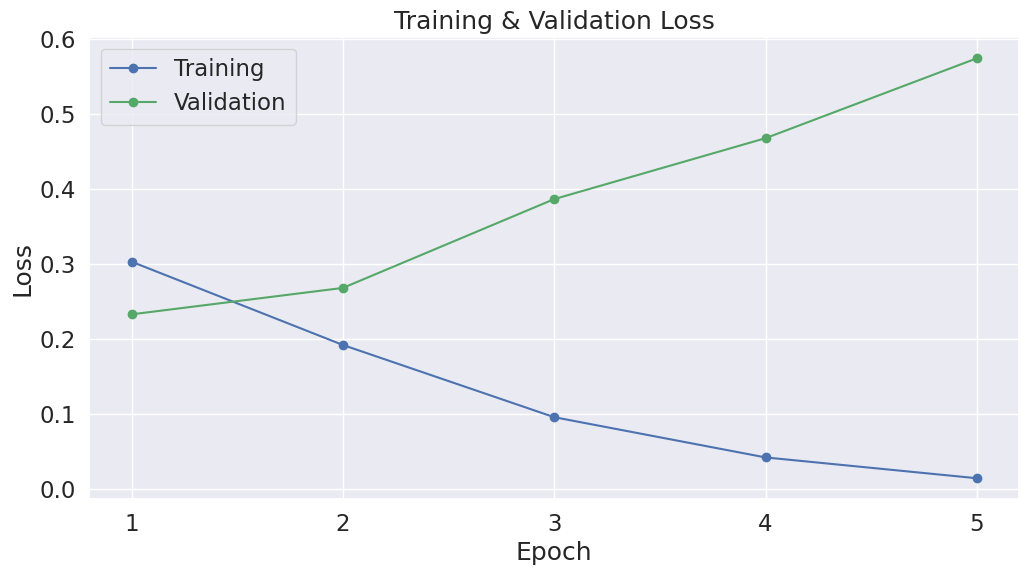

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

Performance test

In [ ]:
import csv

prediction_size = 10000 # small sample for performance test

dataset = dataset_all.sample(testing_size)

print(dataset.sample(10))

                file_id                doc_id          title  author  \
2891162  NWRW1900000051  NWRW1900000051.22049   한겨레 2009년 기사     황보연   
2776970  NWRW1900000051   NWRW1900000051.6346   한겨레 2009년 기사     장세영   
3376090  NWRW1900000055   NWRW1900000055.3851   한겨레 2013년 기사     김광수   
2920022  NWRW1900000051  NWRW1900000051.26098   한겨레 2009년 기사     조경국   
2382095  NWRW1900000009  NWRW1900000009.13929  조선일보 2017년 기사     표태준   
3971810  NWRW1900000060  NWRW1900000060.12351   한겨레 2018년 기사     신민정   
2021844  NWRW1900000008   NWRW1900000008.1364  조선일보 2016년 기사     최규민   
2017208  NWRW1900000008    NWRW1900000008.829  조선일보 2016년 기사     임민혁   
3095409  NWRW1900000053     NWRW1900000053.80   한겨레 2011년 기사     김정필   
2188822  NWRW1900000008  NWRW1900000008.20007  조선일보 2016년 기사  김성모최원우   

        publisher      date  topic  \
2891162       한겨레  20091029     사회   
2776970       한겨레  20090406     사회   
3376090       한겨레  20130410     생활   
2920022       한겨레  20091217  IT/과학   
2382095     조선일보사

In [ ]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(dataset.shape[0]))

# Create sentence and label lists
sentences = dataset.sentence.values
labels = dataset.publisher.values
topics = dataset.topic.values

for i in range(len(labels)):
  if type(labels[i]) == str:
    labels[i] = ["한겨레", "조선일보사"].index(labels[i])

labels = labels.astype(int)

print(topics)

Number of test sentences: 10,000

['스포츠' '사회' 'IT/과학' ... '스포츠' '사회' '생활']


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
# labels = labels.astype(int)
labels = torch.tensor(labels)

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_loader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

print(input_ids.size())
print(attention_masks.size())
print(labels.size())

torch.Size([10000, 128])
torch.Size([10000, 128])
torch.Size([10000])


<ipython-input-22-e5c76e739143>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [ ]:
# Create the DataLoader.
topics_dict = {}
for i in range(len(sentences)):
  topic = topics[i]
  if str(topic) == "nan": continue
  if topic in topics_dict:
    ids, masks, lbls = topics_dict[topics[i]]
    ids.append(input_ids[i])
    masks.append(attention_masks[i])
    lbls.append(labels[i])
  else:
    print("new topic: %s" % topics[i])
    topics_dict[topics[i]] = [[],[],[]]
    ids, masks, lbls = topics_dict[topics[i]]

    ids.append(input_ids[i])
    masks.append(attention_masks[i])
    lbls.append(labels[i])

data_dict = {}
for topic in topics_dict:

    print("%s topics in %s" % (len(topics_dict[topic][2]), topic))
    ids, masks, lbls = topics_dict[topic]
    ids = torch.stack(ids)
    masks = torch.stack(masks)
    lbls = torch.stack(lbls)

    prediction_data = TensorDataset(ids, masks, lbls)
    prediction_sampler = SequentialSampler(prediction_data)
    data_dict[topic] = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


new topic: 스포츠
new topic: 사회
new topic: IT/과학
new topic: 생활
new topic: 미용/건강
new topic: 연예
new topic: 경제
new topic: 문화
new topic: 정치
816 topics in 스포츠
3545 topics in 사회
525 topics in IT/과학
1531 topics in 생활
439 topics in 미용/건강
107 topics in 연예
1252 topics in 경제
684 topics in 문화
857 topics in 정치


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()
model.to(device)

performance_dict = {}

# Tracking variables
for topic in topics_dict:
    print(topic)
    predictions , true_labels = [], []

    loader = data_dict[topic]
    # Predict
    for batch in loader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)

      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

      logits = outputs[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels += list(label_ids)
    performance_dict[topic] = [predictions, true_labels]

print('    DONE.')

Predicting labels for 10,000 test sentences...
스포츠
사회


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import matthews_corrcoef

accuracy_list = []

topics_list = []
# Evaluate each topic using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each topic
for topic in topics_dict:
  topics_list.append(topic)
  print(topic)
  predictions, true_labels = performance_dict[topic]
  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels = []
  for i in range(len(predictions)):
    pred_labels_i = [sigmoid(val[1] - val[0]) for val in list(predictions[i])]
    pred_labels += pred_labels_i

  # Calculate and store the coef for this batch.
  criteria = nn.BCELoss()
  accuracy = sum([1 - abs(pred_labels[i] - true_labels[i]) for i in range(len(true_labels))]) / len(true_labels)
  accuracy_list.append(accuracy)

Calculating Matthews Corr. Coef. for each batch...
사회
3520
3520
경제
1254
1254
스포츠
810
810
IT/과학
534
534
생활
1547
1547
문화
737
737
정치
853
853
미용/건강
399
399
연예
112
112


In [ ]:
print(sum(accuracy_list) / len(accuracy_list))

0.9039524518088123


<ipython-input-27-86d6b9d39390>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=topics_list, y=accuracy_list, ci=None)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

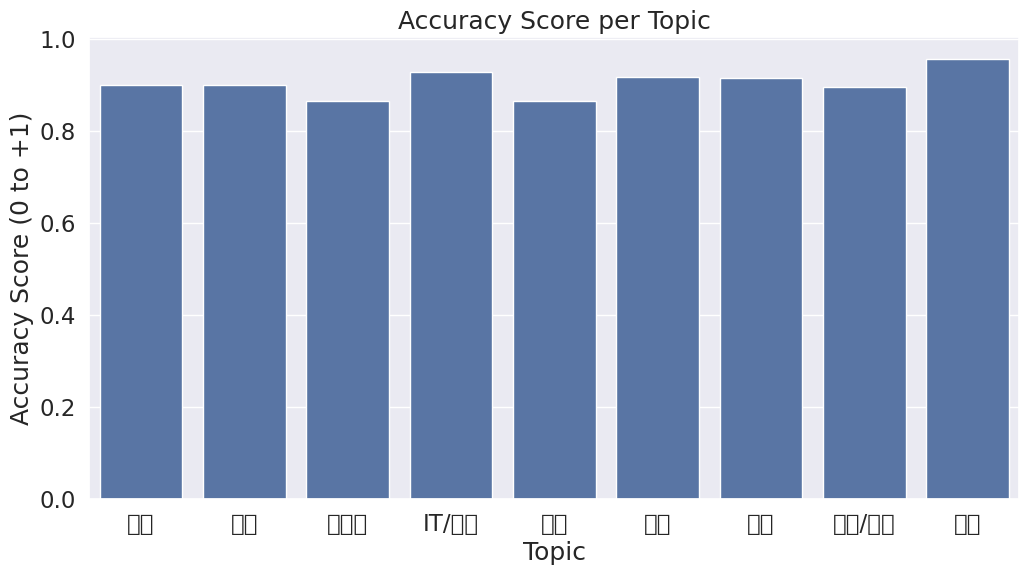

['사회', '경제', '스포츠', 'IT/과학', '생활', '문화', '정치', '미용/건강', '연예']


In [ ]:
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic",
rc={"axes.unicode_minus":False}, style='white')


# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=topics_list, y=accuracy_list, ci=None)

plt.title('Accuracy Score per Topic')
plt.ylabel('Accuracy Score (0 to +1)')
plt.xlabel('Topic')

plt.show()
print(topics_list)

Save model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = gdrive_path + 'model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/gdrive/My Drive/Hackathon/model_save/


('/content/gdrive/My Drive/Hackathon/model_save/tokenizer_config.json',
 '/content/gdrive/My Drive/Hackathon/model_save/special_tokens_map.json',
 '/content/gdrive/My Drive/Hackathon/model_save/vocab.txt',
 '/content/gdrive/My Drive/Hackathon/model_save/added_tokens.json')

Load model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

output_dir = gdrive_path + 'model_save/'

# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05,